# ACTIVIDAD INTEGRADORA


# MÓDULO 3: Modelos de aprendizaje automático y implementación de modelos


## Aprendizaje automático con Apache Spark - Notebook

# Ejercicio : Filtrado Colaborativo o sistema de recomendación

En esta actividad se utilizarpan las componentes `pandas` y `numpy` que son librerías que reúnen muchas herramientas para manejo de dataframe, vectores y matrices, junto a ellas se utilizará la componente `ml.recommendation`

Puedes ejecutar cada una de las celdas de código haciendo click en ellas y presionando `Shift + Enter`.

También puedes editar cualquiera de estas celdas. Las celdas no son independientes. Es decir, sí importa el orden en el que las ejecutes, y cualquier cambio que hagas se reflejará en las celdas que ejecutes después.


# Filtrado Coalborativo


> Definición:


El filtrado colaborativo es una técnica utilizada por los sistemas de recomendación para solventar los problemas derivados de la sobreinformación que los consumidores sufren en Internet. Esta tendencia crece cada día más, debido a su enorme funcionalidad son más los usuarios que se valen de esta herramienta en sus búsquedas.


`Existen diferentes tipos de filtrado a la hora de establecer las recomendaciones, se pueden clasificar en cuatro:`

- Filtrados basado en contenido: las recomendaciones se hacen según los contenidos que puedan gustar o interesar.

- Filtrados demográficos: se realizan por las características de los usuarios (edad, sexo, estudios…).

- Filtrados colaborativos: las recomendaciones están basadas en las búsquedas con votos positivos de usuarios similares.

- Filtrados híbridos: mezclan los dos o tres de los filtrados anteriores para una mejor experiencia.


`y se tienen dos enfoques distintos para emplear el filtrado colaborativo:`

- El filtrado basado en la memoria calcula las similitudes entre los productos o los usuarios.

- El filtrado basado en modelos intenta aprender el patrón subyacente que dicta cómo los usuarios califican o interactúan con los elementos.



> Actividad Integradora


En la actividad se refuerzan los conceptos de _aprendizaje supervisado, además de la utilización de la componente `ml.recommendation` que implementa el algoritmo de los mínimos cuadrados alternos (ALS) para entrenar los modelos de nuestro primer Filtrado Colaborativo.


> Enunciado del problema

Uno de los usos más comunes del big data es predecir lo que quieren los usuarios. Esto permite que Google le muestre anuncios relevantes, Amazon le recomiende productos relevantes y Netflix le recomiende películas que le puedan gustar. Esta práctica de laboratorio demostrará cómo podemos usar Apache Spark para recomendar películas a un usuario. Comenzaremos con algunas técnicas básicas y luego usaremos el método de mínimos cuadrados alternos de la biblioteca Spark ML para hacer predicciones más sofisticadas.

Para esta práctica de laboratorio, utilizaremos un subconjunto de datos de calificaciones. Sin embargo, el mismo código que escriba también funcionará en el conjunto de datos completo (aunque ejecutarlo con el conjunto de datos completo en Community Edition probablemente lleve bastante tiempo).


Cargamos el dataset de películas que podemos obtener en el sitio: https://grouplens.org/datasets/movielens/

![](http://spark-mooc.github.io/web-assets/images/cs110x/movie-camera.png)

In [ ]:
#Instalar Dependencias:
#1.   Java 8
#2.   Apache Spark con hadoop y
#3.   Findspark (usado para localizar spark en el sistema)

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
# Seteamos variables de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
# Validamos que spark este cargado
!ls

sample_data		       spark-3.1.1-bin-hadoop3.2.tgz.1
spark-3.1.1-bin-hadoop3.2      spark-3.1.1-bin-hadoop3.2.tgz.2
spark-3.1.1-bin-hadoop3.2.tgz


Se crea la instancia de spark, utilizando `findspark`, donde podemos comprobar la ruta de donde se carga el spark con `findspark.find()`.

In [ ]:
# Inicializar contexto spark
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

# Usar el método recomendado para obtener o crear SparkSession
spark = SparkSession.builder.appName("rating").getOrCreate()
sc = spark.sparkContext

print("SparkSession y SparkContext inicializados.")
findspark.find()

SparkSession y SparkContext inicializados.


'/content/spark-3.1.1-bin-hadoop3.2'

#### Alternativa de cargar el archivo desde nuestro equipo local

In [ ]:
from google.colab import files
import pandas as pd

# Abrir ventana para subir archivos
uploaded = files.upload()


Saving ratings.csv to ratings.csv
Saving movies.csv to movies.csv


In [ ]:
for fn in uploaded.keys():
 print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

movies_arch = 'movies.csv'
rating_arch = 'ratings.csv'

User uploaded file "ratings.csv" with length 2483723 bytes
User uploaded file "movies.csv" with length 494431 bytes


Los archivos tienen la siguiente información

Archivo movies:

- `movieId`: identificación de la película

- `title`: nombre de la película

- `genres`: género de la película

Archivo ratings:

- `user_id`: identificación del usuario

- `movieId`: identificación de la película

- `rating`: es la votación para la película de un usuario, está en una escala de 1-10 donde 10 es mejor (solo calificaciones enteras)


In [ ]:
# Cargando el set de datos
from pyspark.sql.types import IntegerType, FloatType, StructType, StructField, StringType
schema = StructType([StructField("movieId", IntegerType()),
                     StructField("title", StringType()),
                     StructField("genres", StringType())])
df_movies = spark.read.csv(movies_arch, header=True, inferSchema = True, schema=schema);
df_movies.show(3)
df_movies.printSchema()

from pyspark.sql.types import IntegerType, StructType, StructField, StringType
schema_gender = StructType([StructField("user_id", IntegerType()),
                            StructField("movieId", IntegerType()),
                             StructField("rating", FloatType())])
df_rating = spark.read.csv(rating_arch, header=True, inferSchema = True, schema=schema_gender);
df_rating.show(3)
df_rating.printSchema()

ratingsCount = df_rating.count()
moviesCount = df_movies.count()

print('hay {0} clasificaciones y {1} películas en datasets.'.format(ratingsCount, moviesCount))

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+-------+------+
|user_id|movieId|rating|
+-------+-------+------+
|      1|      1|   4.0|
|      1|      3|   4.0|
|      1|      6|   4.0|
+-------+-------+------+
only showing top 3 rows
root
 |-- user_id: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)

hay 100836 clasificaciones y 9742 películas en datasets.


# Normalización:

El método que se utilizará para normalizar es el `MinMaxScaler` de la componente `pyspark.ml.feature`. Este método estadisticamente realiza la normalización de la siguiente manera:

`MinMaxScaler` transforma un conjunto de datos de filas de vectores, normalizando cada característica individualmente de modo que esté en el rango dado. Toma parámetros:

1.- `min`: 0.0 por defecto. Límite inferior después de la transformación, compartido por todas las características.

2.- `max`: 1.0 por defecto. Límite superior después de la transformación, compartido por todas las características.


Nota: `Para utilizar los escalamientos debemos realizar las transformaciones de variables a vectores y una vez escalado volvemos a dejar la variable como antes para continuar nuestra ejecución.`

In [ ]:
# Vectorizando
from pyspark.ml.feature import VectorAssembler

vector_features = VectorAssembler(inputCols=["rating"], outputCol="features")
df_rating_vec = vector_features.transform(df_rating)
print(df_rating_vec)

DataFrame[user_id: int, movieId: int, rating: float, features: vector]


In [ ]:
# Normalizando valores
from pyspark.ml.feature import MinMaxScaler

standardizer = MinMaxScaler(min=0.0, max=1.0,
                              inputCol='features',
                              outputCol='norm_rating')
modelstd = standardizer.fit(df_rating_vec)
df_rating_norm = modelstd.transform(df_rating_vec)

In [17]:
from pyspark.sql.functions import col

df_rating = df_rating.withColumn(
    "scaled_rating",
    col("rating").cast("double")
)

#ALS no acepta FloatType en algunos entornos, mejor usar DoubleType.


In [18]:
df_rating.printSchema()


root
 |-- user_id: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- scaled_rating: double (nullable = true)



In [19]:
trainingDF, valDF = df_rating.randomSplit([0.8, 0.2], seed=10)


In [21]:
# Mostrar la normalización
from pyspark.sql import functions as f

firstelement=f.udf(lambda v:float(v[0]),FloatType())
df_rating_norm = df_rating_norm.withColumn("norm_rating", firstelement("norm_rating"))
print(df_rating_norm.show(5))

+-------+-------+------+--------+-----------+
|user_id|movieId|rating|features|norm_rating|
+-------+-------+------+--------+-----------+
|      1|      1|   4.0|   [4.0]|  0.7777778|
|      1|      3|   4.0|   [4.0]|  0.7777778|
|      1|      6|   4.0|   [4.0]|  0.7777778|
|      1|     47|   5.0|   [5.0]|        1.0|
|      1|     50|   5.0|   [5.0]|        1.0|
+-------+-------+------+--------+-----------+
only showing top 5 rows
None


# Graficamos la distribución de rating:

Realizamos el gráfico mediante `violin plot` para ver la distribución de los 10.000 primeras marcas de rating

Dato: El `violin plot` combina la funcionalidad del box plot -mostrando los cuartiles de la distribución- y la de la estimación de densidad kernel.

https://seaborn.pydata.org/generated/seaborn.violinplot.html

<Axes: >

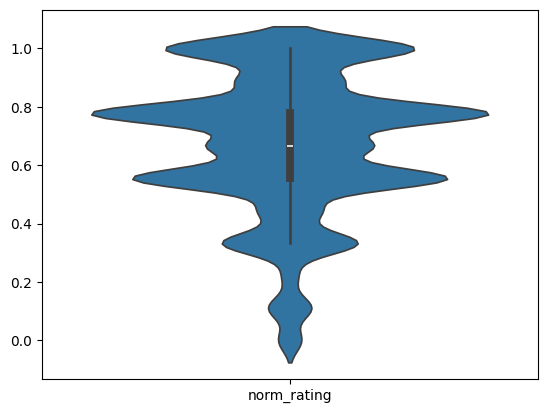

In [22]:
import pandas as pd
import seaborn as sns
# Convertir Spark dataframe en pandas para graficar la distribución
pandas_df = df_rating_norm.limit(10000).toPandas()
sns.violinplot([pandas_df.norm_rating])

# Set de entranamiento, validación y pruebas

Para nuestro caso crearemos un set de entranamiento, uno de validación y uno de pruebas, donde:

- Training set (DataFrame), se utilizará para entrenar el modelo

- Validation set (DataFrame), se utilizará para elegir el mejor modelo, validando lo obtenido en el entrenamiento.

- Test set (DataFrame), Se utilizará para ejecutar nuestro entrenamiento.

Entonces:

In [23]:
# Tomaremos un set de entrenamiento del 60%, 20% para el set de validación y 20% para el set de pruebas
seed=42
(trainingDFT, testDF) = df_rating_norm.randomSplit([0.8, 0.2], seed=seed)
(trainingDF, valDF) = trainingDFT.randomSplit([0.8, 0.2], seed=seed)

print('Training: {0}, val: {1}, test: {2}'.format(trainingDF.count(), valDF.count(), testDF.count()))

Training: 64323, val: 16255, test: 20258


# Entrenamiento

Utilizaremos el filtrado colaborativo basado en modelos:

![](https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif)

Para entrenar el modelo utilizaremos la componente **pyspark.ml.recommendation import ALS**, la definición de la misma en la figura:

![](http://spark-mooc.github.io/web-assets/images/matrix_factorization.png)

# Selección del modelo

El proceso de selección del modelo se realizará a través del análisis de validación cruzada manual y en base a la componente `pyspark.ml.tuning import CrossValidator` (cross-validation) con ajuste automático de hiperparámetros.
Este ajuste se hace definiendo los posibles valores de los hiperparámetros del modelo y ejecutando una búsqueda en rejilla (grid-search) sobre éstas, para comparar la respuesta de los modelos resultantes y finalmente obtener el óptimo. Los hiperparámetros del modelo ALS son:

- rank = la cantidad de factores latentes en el modelo (4, 8 y 12 como valores seleccionados)
- maxIter = el número máximo de iteraciones (valor predeterminado)
- regParam = el parámetro de regularización (0.1, 0.05 y 0.01 como valores seleccionados)

Utilizaremos como medida el mse (mean squared error) para elegir el modelo de menor mse.

`Mean squared error (MSE):` En estadística, el error cuadrático medio (ECM) de un estimador mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima. El ECM es una función de riesgo, correspondiente al valor esperado de la pérdida del error al cuadrado o pérdida cuadrática. La diferencia se produce debido a la aleatoriedad o porque el estimador no tiene en cuenta la información que podría producir una estimación más precisa.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/53ab02a5a1847aa3ff5c6eb69b4023bfb73655f5)

In [20]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

als = ALS() \
    .setMaxIter(5) \
    .setSeed(10) \
    .setUserCol("user_id") \
    .setItemCol("movieId") \
    .setRatingCol("scaled_rating") \
    .setPredictionCol("predictions") \
    .setColdStartStrategy("drop") \
    .setNonnegative(True)



regEval = RegressionEvaluator(
    predictionCol="predictions",
    labelCol="scaled_rating",
    metricName="mse"
)

ranks = [4, 8, 12]
regparams = [0.1, 0.05, 0.01]

min_error = float("inf")
best_model = None
best_rank = None
best_regp = None




for rank in ranks:
    als.setRank(rank)
    for regparam in regparams:
        als.setRegParam(regparam)

        model = als.fit(trainingDF)
        predict_df = model.transform(valDF)

        error = regEval.evaluate(predict_df)

        print(f"Rank={rank}, RegParam={regparam}, MSE={error}")

        if error < min_error:
            min_error = error
            best_model = model
            best_rank = rank
            best_regp = regparam

print("\n✅ Mejor modelo")
print(f"Rank: {best_rank}")
print(f"RegParam: {best_regp}")
print(f"MSE mínimo: {min_error}")

my_model = best_model


Rank=4, RegParam=0.1, MSE=0.8047980255953449
Rank=4, RegParam=0.05, MSE=0.8509628391269128
Rank=4, RegParam=0.01, MSE=0.9666806976017371
Rank=8, RegParam=0.1, MSE=0.7951328647288363
Rank=8, RegParam=0.05, MSE=0.8507387737410468
Rank=8, RegParam=0.01, MSE=1.0090554174942246
Rank=12, RegParam=0.1, MSE=0.7862272931093698
Rank=12, RegParam=0.05, MSE=0.8573788849819585
Rank=12, RegParam=0.01, MSE=1.0497433553266533

✅ Mejor modelo
Rank: 12
RegParam: 0.1
MSE mínimo: 0.7862272931093698


In [27]:
model_final = my_model
print("Mejor modelo entrenado:", model_final)


Mejor modelo entrenado: ALSModel: uid=ALS_44402ce584fe, rank=12


# Evaluación de medidas

Para validar efectividad del modelo también podemos obtener otras medidas que pueden ser útiles para comparar con la nuestra con el objetivo de validar la minimización del error en nuestro modelo, estas son:

`Root Mean Square Error (RMSE):` es una forma estándar de medir el error de un modelo en la predicción de datos cuantitativos. Formalmente se define de la siguiente manera:

![](https://miro.medium.com/max/966/1*lqDsPkfXPGen32Uem1PTNg.png)


`Mean Absolute Error (MAE):` mide la magnitud promedio de los errores en un conjunto de predicciones, sin considerar su dirección. Es el promedio sobre la muestra de prueba de las diferencias absolutas entre la predicción y la observación real donde todas las diferencias individuales tienen el mismo peso.

![](https://miro.medium.com/max/630/1*OVlFLnMwHDx08PHzqlBDag.gif)


`r² metric:` en estadística, el coeficiente de determinación, denominado R² y pronunciado R cuadrado, es un estadístico usado en el contexto de un modelo estadístico cuyo principal propósito es predecir futuros resultados o probar una hipótesis. El coeficiente determina la calidad del modelo para replicar los resultados, y la proporción de variación de los resultados que puede explicarse por el modelo

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/999c9c8c995140c586aff2c9342301846011d44f)

https://es.wikipedia.org/wiki/Coeficiente_de_determinaci%C3%B3n

In [28]:
# Evalaución con mas medidas
predict_dfT = model_final.transform(testDF)

def medidas_evaluation(predictions):
    # Model evaluation in test - ratings regression evaluation
    print("Model evaluation on test data:")
    predictions = predictions.na.drop()
    # RMSE
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="norm_rating", predictionCol="predictions")
    rmse = rmse_evaluator.evaluate(predictions)
    print("Root-mean-square error (RMSE) = " + str(rmse))
    # R2
    r2_evaluator = RegressionEvaluator(metricName="r2", labelCol="norm_rating", predictionCol="predictions")
    r2 = r2_evaluator.evaluate(predictions)
    print("r² metric = " + str(r2))
    # MAE
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="norm_rating", predictionCol="predictions")
    mae = mae_evaluator.evaluate(predictions)
    print("Mean Absolute Error (MAE) = " + str(mae))

    return [rmse, r2, mae]

random_test_eval = medidas_evaluation(predict_dfT)



Model evaluation on test data:
Root-mean-square error (RMSE) = 2.7834728832216844
r² metric = -141.41515757156068
Mean Absolute Error (MAE) = 2.7239755470318276


# Recomendaciones

Finalmente con el modelo ya entrenado podemos validar las recomendaciones, para ello crearemos una función que nos permitirá realizar:

`Recomendación por Usuarios`: Ser realizará una recomendación por una cantidad de usuarios.

`Recomendación de películas para usuarios`: Se realizará una recomendación de película para un grupo de usuarios

`Recomendación para un usuario en particular`: Se realizará una recomendación de películas para un usuario en particular

`Recomendación de película en particular para usuarios`: Se realizará recomendación de 1 película en particular para usuarios

In [29]:
##Mostrar recomendación es una función que retorna el despliegue de datos recomendados por identificación.
##Variables de entrada son:
## Modelo: Modelo entrenado
## df_2: es el dataframe complemento, que no se entreno pero que nos entrega información.
## ident: Es el identificador de lo que queremos desplegar (columna de la predicción)
## Cantidad: Corresponde a la cantidad de datos que desplegará.
## Cantidad_recomendacion: Corresponde a la cantidad de recomendaciones por dato.
## tipo: Si la recomendación será por "Usuario" o por "película"
## variable: Corresponde a un dato opcional, que se ingresa cuando queremos recomendar para un dato en particular o película
##o usuario

def mostrar_recomendacion(modelo, df_2, ident, cantidad, cantidad_recomendacion, tipo, variable = 0):
    datodf = df_2.toPandas()
    if tipo == 'Usuario':
        arrayrecomend = modelo.recommendForAllUsers(cantidad_recomendacion)
        arrayuser = modelo.recommendForAllUsers(cantidad_recomendacion).select(ident)
        if variable > 0:
            recomend = np.array(arrayrecomend.select('recommendations').where(arrayrecomend[ident] == variable).collect(), dtype=int)
            dato = np.array(arrayuser.where(arrayuser[ident] == variable).collect(), dtype=int)
        else:
            recomend = np.array(arrayrecomend.select('recommendations').collect(), dtype=int)
            dato = np.array(arrayuser.collect(), dtype=int)

        recomend_data  = recomend[:, 0, :, 0]
        matrizrecomendacion = np.append(dato,recomend_data, axis = 1)
        #print(matrizrecomendacion)
        nombre = 'Recomendacion'
        recomendacion = pd.DataFrame({tipo: matrizrecomendacion[:cantidad, 0]})
        for j in range(1, cantidad_recomendacion+1):
            pelicula = []
            for i in range(cantidad):
                pelicula.append(datodf['title'][datodf['movieId']==matrizrecomendacion[i, j]].iloc[0])

            recomendacion[nombre+str(j)] = pelicula
    else:
        arrayrecomend = modelo.recommendForAllItems(cantidad_recomendacion)
        arrayuser = modelo.recommendForAllItems(cantidad_recomendacion).select(ident)
        if variable > 0:
            recomend = np.array(arrayrecomend.select('recommendations').where(arrayrecomend[ident] == variable).collect(), dtype=int)
            dato = np.array(arrayuser.where(arrayuser[ident] == variable).collect(), dtype=int)
        else:
            recomend = np.array(arrayrecomend.select('recommendations').collect(), dtype=int)
            dato = np.array(arrayuser.collect(), dtype=int)

        recomend_data  = recomend[:, 0, :, 0]
        nombre = 'Recomendacion'
        recomendacion = pd.DataFrame({tipo: dato[:cantidad, 0]})
        init =0
        for i in range(init, cantidad):
            if i == init:
                recomendacion["Nombre"] = None
            recomendacion["Nombre"].loc[i] = datodf['title'][datodf['movieId']==int(dato[i])].iloc[0]
            for j in range(cantidad_recomendacion):
                if i == init:
                    recomendacion[nombre+str(j+1)] = None
                recomendacion[nombre+str(j+1)].loc[i] = recomend_data[i, j]

    return recomendacion

`Recomendación por Usuarios`, se realizará recomendación de 5 películas para 5 usuarios (se puede variar el número)

In [30]:
from IPython.display import display
despliegue = mostrar_recomendacion(model_final, df_movies, 'user_id', 5, 5, 'Usuario')
display(despliegue)

,Usuario,Recomendacion1,Recomendacion2,Recomendacion3,Recomendacion4,Recomendacion5
0,1,On the Beach (1959),Yojimbo (1961),Saving Face (2004),Neon Genesis Evangelion: The End of Evangelion...,Lady Jane (1986)
1,2,On the Beach (1959),Neon Genesis Evangelion: The End of Evangelion...,Cosmos,De platte jungle (1978),Blue Planet II (2017)
2,3,"Room, The (2003)","Skin I Live In, The (La piel que habito) (2011)",Alien Contamination (1980),Galaxy of Terror (Quest) (1981),Android (1982)
3,4,Kind Hearts and Coronets (1949),I'm the One That I Want (2000),Mulholland Dr. (1999),L.I.E. (2001),Gandhi (1982)
4,5,Cat on a Hot Tin Roof (1958),"General, The (1926)",Lifeboat (1944),Lady Jane (1986),Crossing Delancey (1988)


`Recomendación de películas para usuarios`: Se realizará recomendación de una película para 5 usuarios para cada película

In [31]:
despliegue2 = mostrar_recomendacion(model_final, df_movies, 'movieId', 3, 5, 'Pelicula')
display(despliegue2)

/tmp/ipython-input-1663427683.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  recomendacion["Nombre"].loc[i] = datodf['title'][datodf['movieId']==int(dato[i])].iloc[0]
/tmp/ipython-input-1663427683.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step a

,Pelicula,Nombre,Recomendacion1,Recomendacion2,Recomendacion3,Recomendacion4,Recomendacion5
0,1,Toy Story (1995),43,53,543,578,538
1,3,Grumpier Old Men (1995),543,594,53,389,574
2,5,Father of the Bride Part II (1995),43,201,53,584,498


`Recomendación para un usuario en particular`: Se recomendará 3 películas para el usuario 471

In [33]:
despliegue3 = mostrar_recomendacion(model_final, df_movies, 'user_id', 1, 1, 'Usuario', 471)
display(despliegue3)

,Usuario,Recomendacion1
0,471,"Jetée, La (1962)"


`Recomendación de película en particular para usuarios`: Se recomendará la película `Out Cold (2001)` para 4 usuarios

In [34]:
despliegue4 = mostrar_recomendacion(model_final, df_movies, 'movieId', 1, 4, 'Pelicula', 4900)
display(despliegue4)

/tmp/ipython-input-1663427683.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  recomendacion["Nombre"].loc[i] = datodf['title'][datodf['movieId']==int(dato[i])].iloc[0]
/tmp/ipython-input-1663427683.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step a

,Pelicula,Nombre,Recomendacion1,Recomendacion2,Recomendacion3,Recomendacion4
0,4900,Out Cold (2001),53,43,578,93


Finalizamos deteniendo la sesión de spark (no se debe olvidar este paso)

In [35]:
sc.stop()

# Conclusión

Los algoritmos de filtrado colaborativo nos ayudan a generar recomendaciones a personas de acuerdo a sus gustos o preferencias de personas con gustos similares. Esto es de vital importancia para el negocio, dado que podemos establecer con precisión lo que necesita un usuario y por consiguiente mayor posibilidad de captar una venta.

# Referencias

Filtrado Colaborativo definición: https://es.wikipedia.org/wiki/Filtrado_colaborativo

Filtrado Colaborativo definición y contexto: https://www.iebschool.com/blog/filtrado-colaborativo-sirve-e-commerce/

Filtrado Colaborativo con pyspark: https://medium.com/datos-y-ciencia/intro-als-pyspark-7de7f3ba3b0a

Componente filtrado Colaborativo pyspark: http://spark.apache.org/docs/latest/ml-collaborative-filtering.html

k-nereast Neightbord en python: https://www.aprendemachinelearning.com/clasificar-con-k-nearest-neighbor-ejemplo-en-python/

k-nereast Neightbord aproximación en pyspark: https://spark.apache.org/docs/2.2.0/ml-features.html#approximate-nearest-neighbor-search


###### ***Curso: Machine Learning en la nube***
###### ***Autor: Marcelo Miranda Williams***